In [158]:
import geopandas as gpd
import numpy as np
import pandas as pd

In [159]:
# Escolha do modelo
model = "benchmark"  # "xgboost", "linear" ou "benchmark"

# Caminho do shapefile baseado no modelo
shapefile_path = rf"..\..\Data\Models\PT_FireProg_model_SHAP_{model}.csv"

# Ler o shapefile
df = gpd.read_file(shapefile_path)
cols_to_convert = df.columns.difference(['bad_pred'])
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Mostrar colunas
print(list(df.columns))

['fid', 'fname', 'year', 'id', 'type', 'sdate', 'edate', 'inidoy', 'enddoy', 'source', 'zp_link', 'burn_perio', 'area', 'growth_rat', 'ros_i', 'ros_p', 'int_i', 'int_p', 'duration_i', 'duration_p', 'qc', 'elev_av', 'aspect_sin', 'aspect_cos', 'landform', 'land_use', '1_3y_fir_p', '3_8y_fir_p', '8_ny_fir_p', 'fuel_model', 'f_load_av', 'sW_1m_av', 'sW_3m_av', 'sW_7_av', 'sW_28_av', 'sW_100_av', 'sW_289_av', 't_2m_C_av', 'd_2m_C_av', 'rh_2m_av', 'VPD_Pa_av', 'sP_hPa_av', 'gp_m2s2_av', 'dfmc_av', 'HDW_av', 'Haines_av', 'FWI_12h_av', 'DC_12h_av', 'FFMC_12h_a', 'wv10_kh_av', 'wsin10_av', 'wcos10_av', 'wv100_k_av', 'wsin100_av', 'wcos100_av', 'Recirc', 'CircVar', 't_950_av', 't_850_av', 't_700_av', 't_500_av', 't_300_av', 'rh_950_av', 'rh_850_av', 'rh_700_av', 'rh_500_av', 'rh_300_av', 'wv_950_av', 'wv_850_av', 'wv_700_av', 'wv_500_av', 'wv_300_av', 'wsi_950_av', 'wco_950_av', 'wsi_850_av', 'wco_850_av', 'wsi_700_av', 'wco_700_av', 'wsi_500_av', 'wco_500_av', 'wsi_300_av', 'wco_300_av', 'vwv_

In [160]:
variables_linear = ['duration_p_log', 'HDW_av', 'wSv_1_av', 'sP_hPa_av', 'wco_500_av', '8_ny_fir_p_log', 't_700_av', '3_8y_fir_p_log', 'f_load_av_log', 'VPD_Pa_av_log', 'wco_700_av', 'DC_12h_av_log', 'wv_300_av_log', 'f_start_log']

variables_xgboost = ['duration_p', 'HDW_av', 'Recirc', 'f_start', '3_8y_fir_p', '8_ny_fir_p', 'f_load_av', 'wSv_1_av', 'gT_8_7_av', 'wsin100_av', 'wco_500_av', 'rh_2m_av', 'BLH_m_rt', 'DC_12h_av']

variables_benchmark = ["wv10_kh_av_log", "dfmc_av", "FFMC_12h_a"]


variables_dict = {
    'linear': variables_linear,
    'xgboost': variables_xgboost,
    'benchmark': variables_benchmark
}

variables = variables_dict[model]


In [161]:
print(df.head())

   fid  fname  year    id  type  sdate  edate      inidoy      enddoy  source  \
0   29    NaN  2017   334   NaN    NaN    NaN  221.750000  221.958333     NaN   
1   29    NaN  2017   335   NaN    NaN    NaN  221.958333  222.125000     NaN   
2   29    NaN  2017   338   NaN    NaN    NaN  222.500000  222.604167     NaN   
3   29    NaN  2017   340   NaN    NaN    NaN  222.604167  222.916667     NaN   
4  113    NaN  2023  2669   NaN    NaN    NaN  241.722222  241.784722     NaN   

   ...  ros_p_linear  PredROS_log  PredROS_linear    PredDiff    Err_pct  \
0  ...   1199.641053     6.573569      714.920255 -484.720798 -40.405486   
1  ...    397.497644     6.343991      568.063152  170.565508  42.909816   
2  ...   1092.753836     6.572816      714.381282 -378.372554 -34.625598   
3  ...    584.937417     6.463548      640.332492   55.395075   9.470257   
4  ...    708.321556     6.695254      807.559502   99.237946  14.010296   

   Error_p_abs  bad_pred  shap_wv10_kh_av_log  shap_dfmc


Performance por Faixa de ROS Linear (com range):
             Err_pct_mean  Error_p_abs_mean  PredDiff_mean  PredDiff_std  \
ros_bin                                                                    
Baixo              265.27            267.23         279.24        183.51   
Médio-Baixo         43.06             56.78         140.78        193.46   
Médio-Alto         -19.12             27.88        -168.27        232.76   
Alto               -61.26             61.26       -1288.77        971.57   

             ROS_min  ROS_max  
ros_bin                        
Baixo          16.98   242.07  
Médio-Baixo   242.12   537.92  
Médio-Alto    538.05  1050.25  
Alto         1050.34  7320.94  


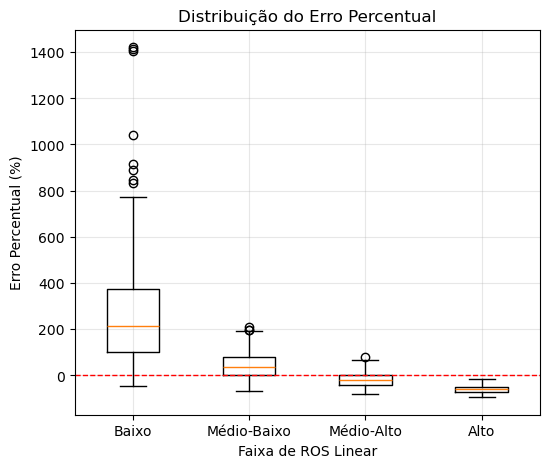

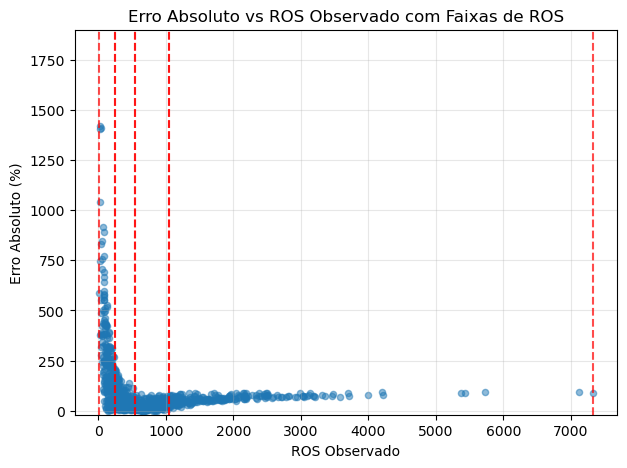

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --------------------------
# Análise por faixas de ROS linear
# --------------------------
# Criar faixas quartis usando ros_p_line
df['ros_bin'] = pd.qcut(df['ros_p_linear'], q=4, labels=['Baixo', 'Médio-Baixo', 'Médio-Alto', 'Alto'])

# Obter range de cada bin
bin_ranges = df.groupby('ros_bin', observed=True)['ros_p_linear'].agg(['min', 'max']).round(2)

# Métricas por faixa
metrics_by_bin = df.groupby('ros_bin', observed=True).agg({
    'Err_pct': 'mean',
    'Error_p_abs': 'mean',
    'PredDiff': ['mean', 'std']
}).round(2)

# Achatar MultiIndex das colunas
metrics_by_bin.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in metrics_by_bin.columns]

# Combinar métricas com range
metrics_by_bin = metrics_by_bin.merge(bin_ranges, left_index=True, right_index=True)
metrics_by_bin = metrics_by_bin.rename(columns={'min':'ROS_min', 'max':'ROS_max'})

print(f"\nPerformance por Faixa de ROS Linear (com range):")
print(metrics_by_bin)

box_data = [
    df[df['ros_bin'] == bin_val]['Err_pct'].values 
    for bin_val in df['ros_bin'].cat.categories
]

# --------------------------
# Gráficos
# --------------------------

# Boxplot dos erros por faixa
plt.figure(figsize=(6,5))
plt.boxplot(box_data, tick_labels=df['ros_bin'].cat.categories)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.xlabel('Faixa de ROS Linear')
plt.ylabel('Erro Percentual (%)')
plt.title('Distribuição do Erro Percentual')
plt.grid(True, alpha=0.3)
plt.show()

# =========================================================
# 7. Erro absoluto vs ROS observado
# =========================================================
plt.figure(figsize=(7,5))

# Scatter dos erros absolutos
plt.scatter(df['ros_p'], df['Error_p_abs'], alpha=0.5, s=20)

# Adicionar linhas verticais nos limites das faixas de ROS
for _, row in bin_ranges.iterrows():
    plt.axvline(x=row['min'], color='red', linestyle='--', alpha=0.7)
    plt.axvline(x=row['max'], color='red', linestyle='--', alpha=0.7)

plt.xlabel('ROS Observado')
plt.ylabel('Erro Absoluto (%)')
plt.title('Erro Absoluto vs ROS Observado com Faixas de ROS')
plt.ylim(-20, 1900)
plt.grid(True, alpha=0.3)
plt.show()


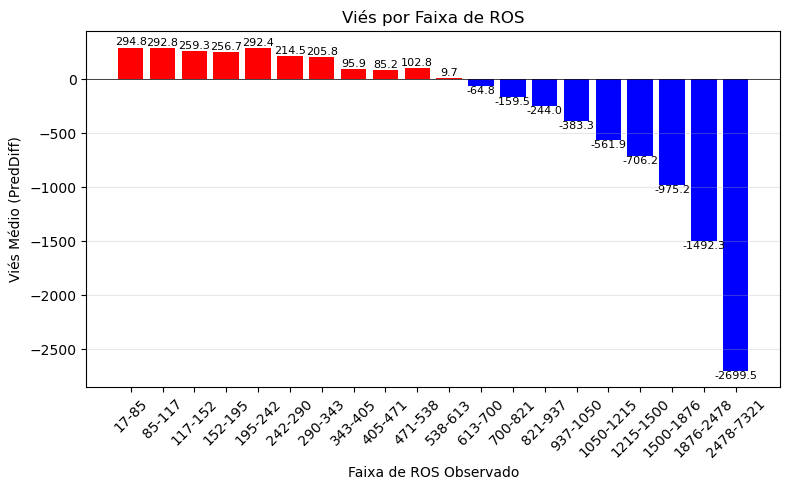

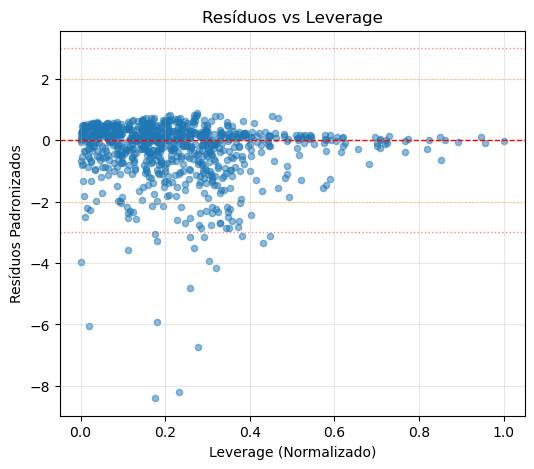


ESTATÍSTICAS DOS RESÍDUOS:
  Média: -259.361
  Desvio Padrão: 804.392
  Skewness: -2.915
  Kurtosis: 14.121
  Teste de Normalidade (Shapiro-Wilk): Estatística: 0.7505, p-value: 0.0000
  Normal? NÃO


In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# =========================================================
# Viés por Faixa de ROS (linear, 8 bins, barras lado a lado, labels início-fim)
# =========================================================
if 'ros_p_linear' in df.columns:
    # Criar 8 faixas usando qcut
    ros_bins = pd.qcut(df['ros_p_linear'], q=20, duplicates='drop')
    df['ros_bin_lin'] = ros_bins

    bias_by_bin = []
    bin_labels = []

    for bin_cat in df['ros_bin_lin'].cat.categories:
        bin_data = df[df['ros_bin_lin'] == bin_cat]
        if len(bin_data) > 0:
            # Viés médio
            bias = bin_data['PredDiff'].mean()
            bias_by_bin.append(bias)
            
            # Label com início e fim do bin
            bin_labels.append(f'{bin_cat.left:.0f}-{bin_cat.right:.0f}')

    # Cores: vermelho para viés positivo, azul para negativo
    colors = ['red' if b > 0 else 'blue' for b in bias_by_bin]

    plt.figure(figsize=(8,5))
    bars = plt.bar(range(len(bias_by_bin)), bias_by_bin, color=colors, align='center')
    
    plt.axhline(y=0, color='black', linewidth=0.5)
    plt.xlabel('Faixa de ROS Observado')
    plt.ylabel('Viés Médio (PredDiff)')
    plt.title('Viés por Faixa de ROS')
    plt.xticks(range(len(bin_labels)), bin_labels, rotation=45)
    plt.grid(True, alpha=0.3, axis='y')

    # Adicionar valores sobre as barras
    for bar, bias in zip(bars, bias_by_bin):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., 
                 height + (0.1 if height >= 0 else -0.3),
                 f'{bias:.1f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# =========================================================
# 5. Resíduos Padronizados vs Leverage
# =========================================================
if model != 'xgboost':
    if len(df) > 1:
        residuals = df['PredDiff'].values
        std_residuals = residuals / np.std(residuals)
        pred_mean = df['PredROS_log'].mean()
        leverage = np.abs(df['PredROS_log'] - pred_mean)
        leverage = leverage / leverage.max()

        plt.figure(figsize=(6,5))
        plt.scatter(leverage, std_residuals, alpha=0.5, s=20)
        plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
        plt.axhline(y=2, color='orange', linestyle=':', linewidth=1, alpha=0.5)
        plt.axhline(y=-2, color='orange', linestyle=':', linewidth=1, alpha=0.5)
        plt.axhline(y=3, color='red', linestyle=':', linewidth=1, alpha=0.5)
        plt.axhline(y=-3, color='red', linestyle=':', linewidth=1, alpha=0.5)
        plt.xlabel('Leverage (Normalizado)')
        plt.ylabel('Resíduos Padronizados')
        plt.title('Resíduos vs Leverage')
        plt.grid(True, alpha=0.3)
        plt.show()

# =========================================================
# Estatísticas dos resíduos
# =========================================================
print("\nESTATÍSTICAS DOS RESÍDUOS:")
print(f"  Média: {df['PredDiff'].mean():.3f}")
print(f"  Desvio Padrão: {df['PredDiff'].std():.3f}")
print(f"  Skewness: {stats.skew(df['PredDiff'].dropna()):.3f}")
print(f"  Kurtosis: {stats.kurtosis(df['PredDiff'].dropna()):.3f}")

if len(df) > 3 and len(df) < 5000:
    stat, p_value = stats.shapiro(df['PredDiff'].dropna())
    print(f"  Teste de Normalidade (Shapiro-Wilk): Estatística: {stat:.4f}, p-value: {p_value:.4f}")
    print(f"  Normal? {'SIM' if p_value > 0.05 else 'NÃO'}")


ANÁLISE DE MÁS PREVISÕES

1. DISTRIBUIÇÃO DE PREVISÕES:
   Total de observações: 851
   Boas previsões: 265 (31.1%)
   Más previsões: 586 (68.9%)

2. MÉTRICAS DE ERRO:
   MAE (todas): 498.10
   MAE (boas): 111.84
   MAE (más): 672.78

   MAPE (todas): 103.38%
   MAPE (boas): 17.45%
   MAPE (más): 142.23%

3. DISTRIBUIÇÃO DOS ERROS (%):
   Mínimo erro: -94.82%
   Máximo erro: 1421.25%
   Mediana erro: 1.01%
   IQR erro: 135.26%


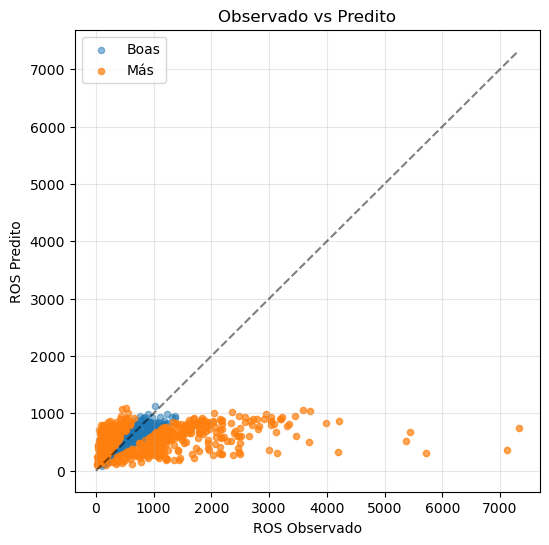

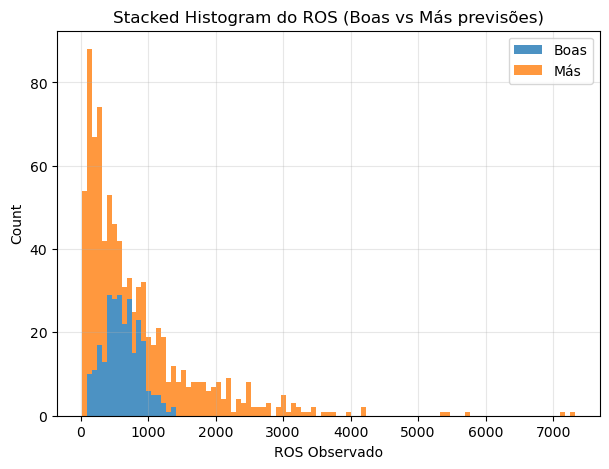


Correlação com erro absoluto:
   wv10_kh_av_log: 0.026
   dfmc_av: 0.111
   FFMC_12h_a: -0.075
   Error_p_abs: 1.000


In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# =========================================================
# 1. Separar boas e más previsões
# =========================================================
bad_preds = df[df['bad_pred'] == 'True'].copy()
good_preds = df[df['bad_pred'] == 'False'].copy()



# =========================================================
# 2. Análise descritiva
# =========================================================
print("=" * 80)
print("ANÁLISE DE MÁS PREVISÕES")
print("=" * 80)

print(f"\n1. DISTRIBUIÇÃO DE PREVISÕES:")
print(f"   Total de observações: {len(df)}")
print(f"   Boas previsões: {len(good_preds)} ({len(good_preds)/len(df)*100:.1f}%)")
print(f"   Más previsões: {len(bad_preds)} ({len(bad_preds)/len(df)*100:.1f}%)")

print(f"\n2. MÉTRICAS DE ERRO:")
print(f"   MAE (todas): {df['PredDiff'].abs().mean():.2f}")
print(f"   MAE (boas): {good_preds['PredDiff'].abs().mean():.2f}")
print(f"   MAE (más): {bad_preds['PredDiff'].abs().mean():.2f}")

print(f"\n   MAPE (todas): {df['Error_p_abs'].mean():.2f}%")
print(f"   MAPE (boas): {good_preds['Error_p_abs'].mean():.2f}%")
print(f"   MAPE (más): {bad_preds['Error_p_abs'].mean():.2f}%")

print(f"\n3. DISTRIBUIÇÃO DOS ERROS (%):")
print(f"   Mínimo erro: {df['Err_pct'].min():.2f}%")
print(f"   Máximo erro: {df['Err_pct'].max():.2f}%")
print(f"   Mediana erro: {df['Err_pct'].median():.2f}%")
print(f"   IQR erro: {(df['Err_pct'].quantile(0.75) - df['Err_pct'].quantile(0.25)):.2f}%")


# =========================================================
# 5. Observado vs Predito
# =========================================================
plt.figure(figsize=(6,6))

plt.scatter(
    good_preds['ros_p'], good_preds['PredROS_linear'],
    alpha=0.5, label='Boas', s=20
)

plt.scatter(
    bad_preds['ros_p'], bad_preds['PredROS_linear'],
    alpha=0.7, label='Más', s=20
)

max_val = max(df['ros_p'].max(), df['PredROS_linear'].max())
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)

plt.xlabel('ROS Observado')
plt.ylabel('ROS Predito')
plt.title('Observado vs Predito')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# =========================================================
# 6. Distribuição do erro absoluto
# =========================================================
# Definir bins comuns em ROS (comparação justa)
ros_min = df['ros_p'].min()
ros_max = df['ros_p'].max()
bins = np.linspace(ros_min, ros_max, 100)

plt.figure(figsize=(7,5))

plt.hist(
    [good_preds['ros_p'], bad_preds['ros_p']],
    bins=bins,
    stacked=True,
    density=False,
    label=['Boas', 'Más'],
    alpha=0.8
)

plt.xlabel('ROS Observado')
plt.ylabel('Count')
plt.title('Stacked Histogram do ROS (Boas vs Más previsões)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# =========================================================
# 9. Correlação com erro absoluto
# =========================================================
corr_vars = variables.copy()
corr_vars.append('Error_p_abs')
corr = df[corr_vars].corr()['Error_p_abs']

print("\nCorrelação com erro absoluto:")
for var, val in corr.items():
    print(f"   {var}: {val:.3f}")


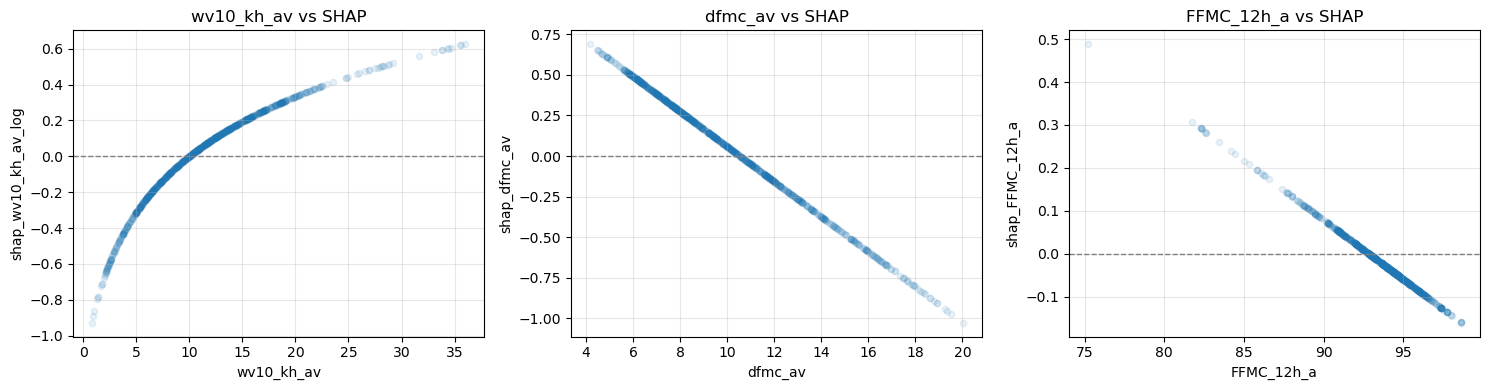

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Criar var_to_shap automaticamente a partir de corr_vars
var_to_shap = {var: 'shap_' + var for var in variables}

variables = list(var_to_shap.keys())
n_vars = len(variables)

# Configurar número de colunas e linhas de forma dinâmica
n_cols = 3
n_rows = math.ceil(n_vars / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, var in enumerate(variables):
    shap_var = var_to_shap[var]
    ax = axes[i]

    # Verificar se as colunas existem
    if var not in df.columns or shap_var not in df.columns:
        ax.set_title(f'{var} / {shap_var}\n(Não encontrado)')
        ax.set_xticks([])
        ax.set_yticks([])
        continue

    # Preparar dados
    data = df[[var, shap_var]].dropna().copy()

    # Reverter log-safe para escala linear se a variável terminar com "_log"
    if var.endswith('_log'):
        data[var] = np.sign(data[var]) * (np.exp(np.abs(data[var])) - 1)

    # Scatter plot
    ax.scatter(data[var], data[shap_var], alpha=0.1, s=20)

    # Linha horizontal em y=0
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Remover "_log" do label do eixo x
    xlabel = var.replace('_log', '')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(shap_var)
    ax.set_title(f'{xlabel} vs SHAP')
    ax.grid(True, alpha=0.3)

# Remover axes extras se houver
for j in range(n_vars, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


ANÁLISE DOS VALORES SHAP

wv10_kh_av_log (shap_wv10_kh_av_log):
  SHAP médio (más): 0.0045
  SHAP médio (boas): -0.0032
  |SHAP| médio (más): 0.2122
  |SHAP| médio (boas): 0.2177

dfmc_av (shap_dfmc_av):
  SHAP médio (más): 0.0329
  SHAP médio (boas): 0.1083
  |SHAP| médio (más): 0.3028
  |SHAP| médio (boas): 0.3059

FFMC_12h_a (shap_FFMC_12h_a):
  SHAP médio (más): -0.0120
  SHAP médio (boas): -0.0189
  |SHAP| médio (más): 0.0558
  |SHAP| médio (boas): 0.0561


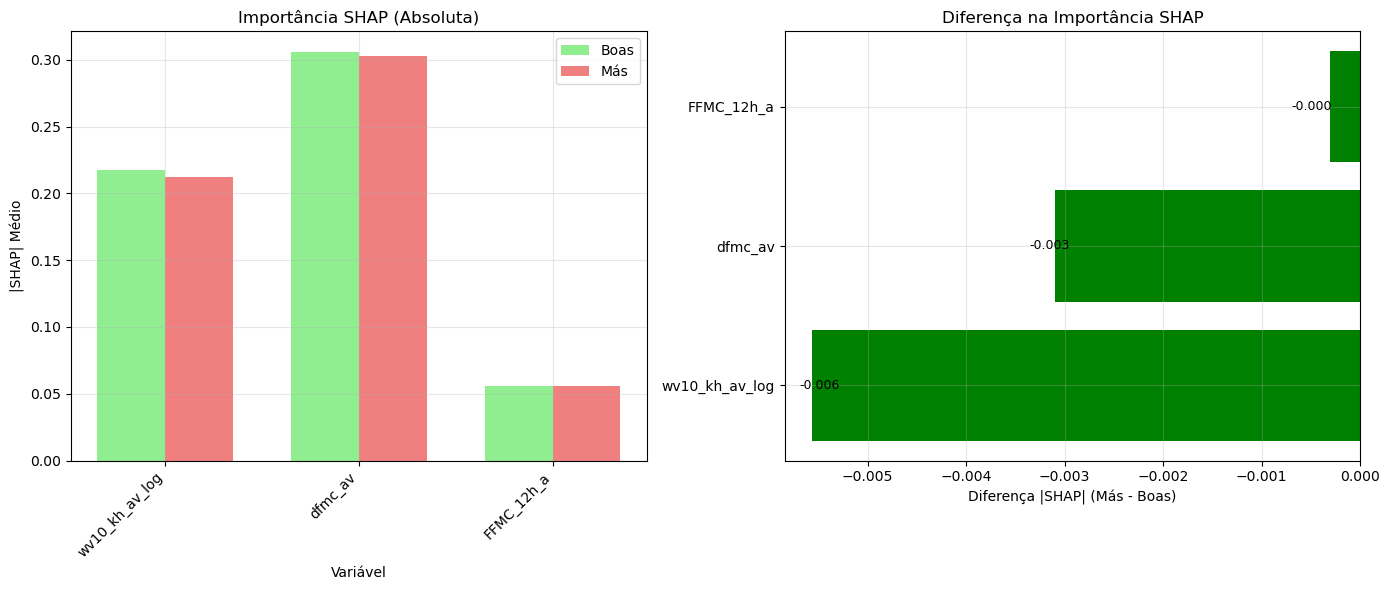

In [166]:
# =========================================================
# 2. Mapeamento de variáveis para SHAP
# =========================================================
print("=" * 80)
print("ANÁLISE DOS VALORES SHAP")
print("=" * 80)

shap_results = {}

for var, shap_var in var_to_shap.items():
    if shap_var in df.columns and var in df.columns:
        if len(bad_preds) == 0 or len(good_preds) == 0:
            print(f"\nATENÇÃO: Sem dados para {var}")
            continue

        # Valores SHAP médios
        bad_shap_mean = bad_preds[shap_var].mean()
        good_shap_mean = good_preds[shap_var].mean()
        bad_shap_abs_mean = bad_preds[shap_var].abs().mean()
        good_shap_abs_mean = good_preds[shap_var].abs().mean()

        shap_results[var] = {
            'bad_shap_mean': bad_shap_mean,
            'good_shap_mean': good_shap_mean,
            'bad_shap_abs_mean': bad_shap_abs_mean,
            'good_shap_abs_mean': good_shap_abs_mean,
            'shap_diff': bad_shap_abs_mean - good_shap_abs_mean
        }

        print(f"\n{var} ({shap_var}):")
        print(f"  SHAP médio (más): {bad_shap_mean:.4f}")
        print(f"  SHAP médio (boas): {good_shap_mean:.4f}")
        print(f"  |SHAP| médio (más): {bad_shap_abs_mean:.4f}")
        print(f"  |SHAP| médio (boas): {good_shap_abs_mean:.4f}")
        
# =========================================================
# 4. Gráficos comparativos de SHAP médio
# =========================================================
if shap_results and len(shap_results) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    variables = list(shap_results.keys())
    bad_shap_abs = [shap_results[var]['bad_shap_abs_mean'] for var in variables]
    good_shap_abs = [shap_results[var]['good_shap_abs_mean'] for var in variables]

    x = np.arange(len(variables))
    width = 0.35

    # SHAP absolutos
    ax1.bar(x - width/2, good_shap_abs, width, label='Boas', color='lightgreen')
    ax1.bar(x + width/2, bad_shap_abs, width, label='Más', color='lightcoral')

    ax1.set_xlabel('Variável')
    ax1.set_ylabel('|SHAP| Médio')
    ax1.set_title('Importância SHAP (Absoluta)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(variables, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Diferença SHAP
    shap_diffs = [shap_results[var]['shap_diff'] for var in variables]
    colors = ['red' if diff > 0 else 'green' for diff in shap_diffs]

    ax2.barh(variables, shap_diffs, color=colors)
    ax2.set_xlabel('Diferença |SHAP| (Más - Boas)')
    ax2.set_title('Diferença na Importância SHAP')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax2.grid(True, alpha=0.3)

    for j, diff in enumerate(shap_diffs):
        ax2.text(diff * 1.05 if diff >= 0 else diff * 0.95, j, f'{diff:.3f}', va='center',
                 ha='left' if diff >= 0 else 'right', fontsize=9)

    plt.tight_layout()
    plt.show()

MODEL SENSITIVITY ANALYSIS (P90)


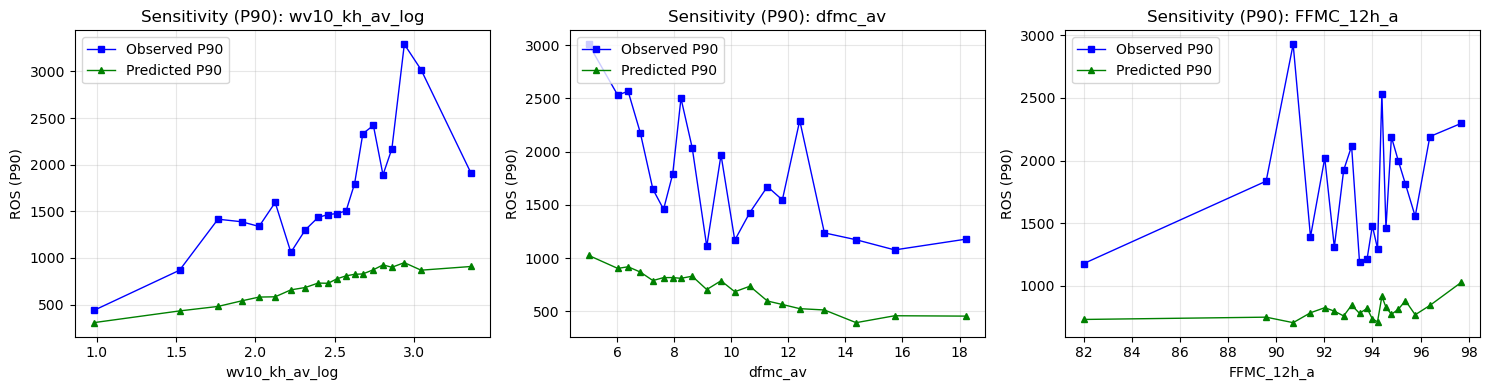

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("=" * 80)
print("MODEL SENSITIVITY ANALYSIS (P90)")
print("=" * 80)

n = 20

# Selecionar variáveis presentes no dataframe
predictor_vars = [v for v in variables if v in df.columns]

n_vars = len(predictor_vars)

# Determinar número de linhas e colunas para o subplot
n_cols = 3
n_rows = int(np.ceil(n_vars / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

# Achatar axes caso seja 2D ou 1D
if n_rows == 1 and n_cols == 1:
    axes = np.array([axes])
elif n_rows == 1 or n_cols == 1:
    axes = axes.flatten()
else:
    axes = axes.flatten()

for i, var in enumerate(predictor_vars):
    ax = axes[i]
    if len(df[var].dropna()) > 0:
        # Criar 10 bins
        bins = pd.qcut(df[var], q=n, duplicates='drop')
        
        pred_by_bin = []
        obs_by_bin = []
        bin_centers = []
        
        for bin_cat in bins.cat.categories:
            bin_mask = bins == bin_cat
            bin_data = df[bin_mask]
            
            if len(bin_data) > 0:
                pred_by_bin.append(bin_data['PredROS_linear'].quantile(0.9))
                obs_by_bin.append(bin_data['ros_p_linear'].quantile(0.9))
                bin_centers.append((bin_cat.left + bin_cat.right) / 2)
        
        ax.plot(bin_centers, obs_by_bin, 's-', linewidth=1, markersize=4,
                color='blue', label='Observed P90')
        ax.plot(bin_centers, pred_by_bin, '^-', linewidth=1, markersize=4,
                color='green', label='Predicted P90')
        
        ax.set_xlabel(var)
        ax.set_ylabel('ROS (P90)')
        ax.set_title(f'Sensitivity (P90): {var}')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left')
        
        # Ajuste de escala se variável específica
        if var == 'f_start':
            ax.set_xscale('log')

# Remover axes extras se houver
for j in range(n_vars, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


ANÁLISE COMPLETA DE TODAS AS INTERAÇÕES COM HEATMAPS
Variáveis preditoras disponíveis: ['wv10_kh_av_log', 'dfmc_av', 'FFMC_12h_a']
Número total de combinações: 3

Calculando interações para todos os pares...
  Processando 3/3: dfmc_av × FFMC_12h_aC_12h_a

Interações válidas encontradas: 3
Média de observações por par: 851
Média de células com dados: 25.0


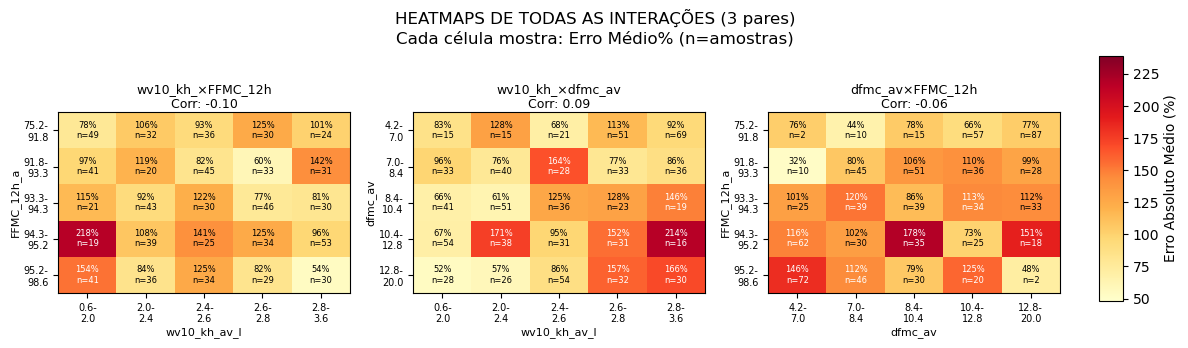

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

print("=" * 80)
print("ANÁLISE COMPLETA DE TODAS AS INTERAÇÕES COM HEATMAPS")
print("=" * 80)

# Variáveis preditoras
predictor_vars = variables.copy()

# Filtrar apenas variáveis presentes
predictor_vars = [v for v in predictor_vars if v in df.columns]


print(f"Variáveis preditoras disponíveis: {predictor_vars}")

# Gerar todas as combinações possíveis
all_pairs = list(itertools.combinations(predictor_vars, 2))
n_pairs = len(all_pairs)
print(f"Número total de combinações: {n_pairs}")

interaction_results = []

print("\nCalculando interações para todos os pares...")
for idx, (var1, var2) in enumerate(all_pairs, 1):
    print(f"  Processando {idx}/{n_pairs}: {var1} × {var2}", end='\r')
    
    valid_data = df[[var1, var2, 'Error_p_abs', 'ros_p_log', 'PredROS_log']].dropna()
    if len(valid_data) < 5:
        continue
    
    try:
        # Correlação do termo de interação com erro
        var1_std = (valid_data[var1] - valid_data[var1].mean()) / valid_data[var1].std()
        var2_std = (valid_data[var2] - valid_data[var2].mean()) / valid_data[var2].std()
        interaction_term = var1_std * var2_std
        corr_with_error = interaction_term.corr(valid_data['Error_p_abs'])
        
        # Heatmap
        n_bins = 5
        x_bins = pd.qcut(valid_data[var1], q=n_bins, duplicates='drop')
        y_bins = pd.qcut(valid_data[var2], q=n_bins, duplicates='drop')
        
        error_matrix = np.full((n_bins, n_bins), np.nan)
        ros_matrix = np.full((n_bins, n_bins), np.nan)
        pred_matrix = np.full((n_bins, n_bins), np.nan)
        count_matrix = np.zeros((n_bins, n_bins))
        
        for i, x_bin in enumerate(x_bins.cat.categories):
            for j, y_bin in enumerate(y_bins.cat.categories):
                mask = (x_bins == x_bin) & (y_bins == y_bin)
                if mask.sum() > 0:
                    cell_data = valid_data[mask]
                    error_matrix[i, j] = cell_data['Error_p_abs'].mean()
                    ros_matrix[i, j] = cell_data['ros_p_log'].mean()
                    pred_matrix[i, j] = cell_data['PredROS_log'].mean()
                    count_matrix[i, j] = mask.sum()
        
        error_variance = np.nanvar(error_matrix)
        max_effect = np.nanmax(error_matrix) - np.nanmin(error_matrix) if np.sum(~np.isnan(error_matrix)) > 1 else np.nan
        
        interaction_results.append({
            'var1': var1,
            'var2': var2,
            'correlation': corr_with_error,
            'abs_correlation': abs(corr_with_error),
            'error_variance': error_variance,
            'max_effect': max_effect,
            'n_obs': len(valid_data),
            'n_cells_with_data': np.sum(count_matrix > 0),
            'x_bins': x_bins,
            'y_bins': y_bins,
            'error_matrix': error_matrix,
            'ros_matrix': ros_matrix,
            'pred_matrix': pred_matrix,
            'count_matrix': count_matrix
        })
    except:
        continue

results_df = pd.DataFrame(interaction_results)
print("\n" + "=" * 80)
print(f"\nInterações válidas encontradas: {len(results_df)}")
print(f"Média de observações por par: {results_df['n_obs'].mean():.0f}")
print(f"Média de células com dados: {results_df['n_cells_with_data'].mean():.1f}")

# Ordenar por correlação absoluta
results_sorted = results_df.sort_values('abs_correlation', ascending=False)

# Heatmaps para todas as interações
n_interactions = len(results_sorted)
n_cols = min(5, n_interactions)
n_rows = int(np.ceil(n_interactions / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3.5))
axes = axes.flatten() if n_interactions > 1 else np.array([axes])

for idx, interaction in enumerate(results_sorted.itertuples()):
    ax = axes[idx]
    var1, var2 = interaction.var1, interaction.var2
    error_matrix = interaction.error_matrix
    count_matrix = interaction.count_matrix
    x_bins = interaction.x_bins
    y_bins = interaction.y_bins

    if np.sum(~np.isnan(error_matrix)) > 0:
        vmin = np.nanmin(error_matrix) * 0.9
        vmax = np.nanmax(error_matrix) * 1.1
        im = ax.imshow(error_matrix, cmap='YlOrRd', aspect='auto', vmin=vmin, vmax=vmax)

        x_labels = [f'{cat.left:.1f}-\n{cat.right:.1f}' for cat in x_bins.cat.categories]
        y_labels = [f'{cat.left:.1f}-\n{cat.right:.1f}' for cat in y_bins.cat.categories]

        ax.set_xticks(range(len(x_labels)))
        ax.set_yticks(range(len(y_labels)))
        ax.set_xticklabels(x_labels, fontsize=7)
        ax.set_yticklabels(y_labels, fontsize=7)

        # Adicionar valores
        for i in range(error_matrix.shape[0]):
            for j in range(error_matrix.shape[1]):
                if not np.isnan(error_matrix[i, j]) and count_matrix[i, j] > 0:
                    text_color = 'white' if error_matrix[i, j] > (vmin + vmax)/2 else 'black'
                    ax.text(j, i, f'{error_matrix[i, j]:.0f}%\nn={int(count_matrix[i, j])}',
                            ha="center", va="center", color=text_color, fontsize=6)

        ax.set_title(f'{var1[:8]}×{var2[:8]}\nCorr: {interaction.correlation:.2f}', fontsize=9, pad=3)
        ax.set_xlabel(var1[:12], fontsize=8, labelpad=2)
        ax.set_ylabel(var2[:12], fontsize=8, labelpad=2)
    else:
        ax.text(0.5, 0.5, 'Sem dados\nsuficientes', ha='center', va='center', transform=ax.transAxes, fontsize=9)
        ax.set_title(f'{var1[:8]}×{var2[:8]}', fontsize=9)

# Remover eixos extras
for i in range(len(results_sorted), len(axes)):
    fig.delaxes(axes[i])

# Colorbar
if len(results_sorted) > 0:
    last_im = axes[0].images[0]  # Pega primeiro heatmap válido
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(last_im, cax=cbar_ax, label='Erro Absoluto Médio (%)')

plt.suptitle(f'HEATMAPS DE TODAS AS INTERAÇÕES ({len(results_df)} pares)\nCada célula mostra: Erro Médio% (n=amostras)', 
                fontsize=12, y=0.98)
plt.tight_layout(rect=[0, 0, 0.9, 0.96])
plt.show()


ANÁLISE DE CLUSTER PARA GRANDES ERROS - PARTE 1

Distribuição:
  Total observações: 851
  Grandes erros (> 35%): 586 (68.9%)
  Baixos erros: 265 (31.1%)


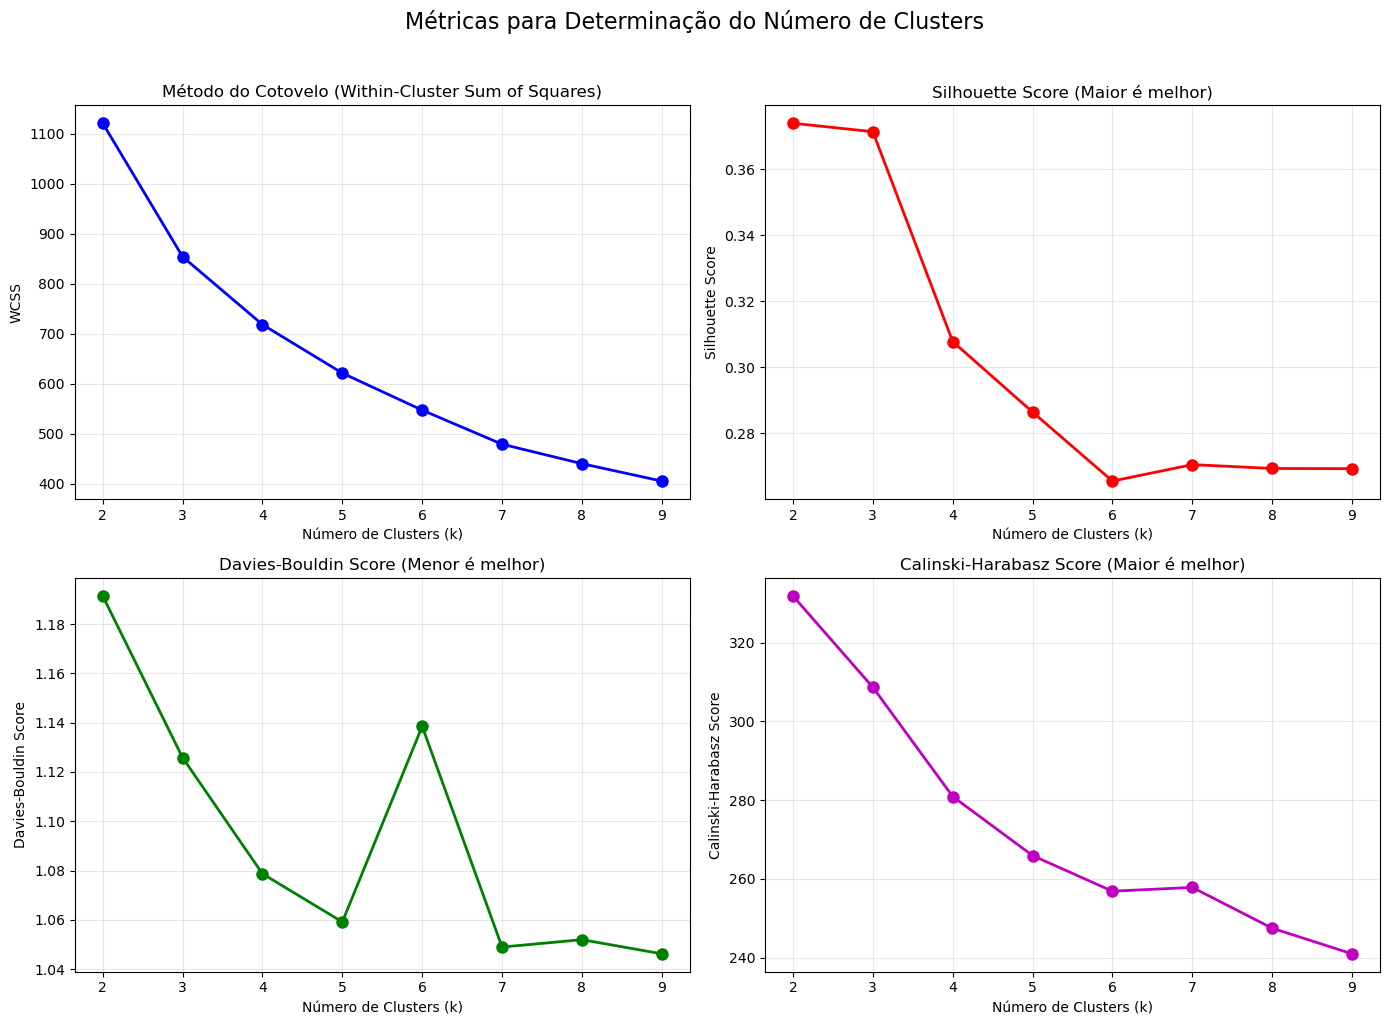

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.patches import Ellipse
import warnings

warnings.filterwarnings('ignore')

# --- Parte 1: Exploração e Plots iniciais ---
print("="*80)
print("ANÁLISE DE CLUSTER PARA GRANDES ERROS - PARTE 1")
print("="*80)

# Preparação dos dados
df_clean = df.copy()

high_error_data = df_clean[df_clean['bad_pred'] == 'True'].copy()
low_error_data  = df_clean[df_clean['bad_pred'] == 'False'].copy()

print(f"\nDistribuição:")
print(f"  Total observações: {len(df_clean)}")
print(f"  Grandes erros (> 35%): {len(high_error_data)} ({len(high_error_data)/len(df_clean)*100:.1f}%)")
print(f"  Baixos erros: {len(low_error_data)} ({len(low_error_data)/len(df_clean)*100:.1f}%)")

# Variáveis para análise de cluster
cluster_vars = variables
cluster_vars = [v for v in cluster_vars if v in df_clean.columns]

X = high_error_data[cluster_vars].fillna(high_error_data[cluster_vars].mean())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Determinação do número ótimo de clusters ---
k_range = range(2, min(10, len(X_scaled)//5 + 1))
wcss, silhouette_scores, db_scores, ch_scores = [], [], [], []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    if len(X_scaled) > k:
        labels = kmeans.labels_
        silhouette_scores.append(silhouette_score(X_scaled, labels))
        db_scores.append(davies_bouldin_score(X_scaled, labels))
        ch_scores.append(calinski_harabasz_score(X_scaled, labels))
    else:
        silhouette_scores.append(np.nan)
        db_scores.append(np.nan)
        ch_scores.append(np.nan)

# --- Plots combinados em 2x2 ---
fig, axes = plt.subplots(2, 2, figsize=(14,10))

# 1. Método do Cotovelo (WCSS)
axes[0,0].plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
axes[0,0].set_xlabel('Número de Clusters (k)')
axes[0,0].set_ylabel('WCSS')
axes[0,0].set_title('Método do Cotovelo (Within-Cluster Sum of Squares)')
axes[0,0].grid(True, alpha=0.3)

# 2. Silhouette Score
axes[0,1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[0,1].set_xlabel('Número de Clusters (k)')
axes[0,1].set_ylabel('Silhouette Score')
axes[0,1].set_title('Silhouette Score (Maior é melhor)')
axes[0,1].grid(True, alpha=0.3)

# 3. Davies-Bouldin Score
axes[1,0].plot(k_range, db_scores, 'go-', linewidth=2, markersize=8)
axes[1,0].set_xlabel('Número de Clusters (k)')
axes[1,0].set_ylabel('Davies-Bouldin Score')
axes[1,0].set_title('Davies-Bouldin Score (Menor é melhor)')
axes[1,0].grid(True, alpha=0.3)

# 4. Calinski-Harabasz Score
axes[1,1].plot(k_range, ch_scores, 'mo-', linewidth=2, markersize=8)
axes[1,1].set_xlabel('Número de Clusters (k)')
axes[1,1].set_ylabel('Calinski-Harabasz Score')
axes[1,1].set_title('Calinski-Harabasz Score (Maior é melhor)')
axes[1,1].grid(True, alpha=0.3)

plt.suptitle('Métricas para Determinação do Número de Clusters', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


APLICANDO K-MEANS COM 4 CLUSTERS

Distribuição dos clusters:
  Cluster 0: 169 observações (28.8%)
  Cluster 1: 130 observações (22.2%)
  Cluster 2: 53 observações (9.0%)
  Cluster 3: 234 observações (39.9%)


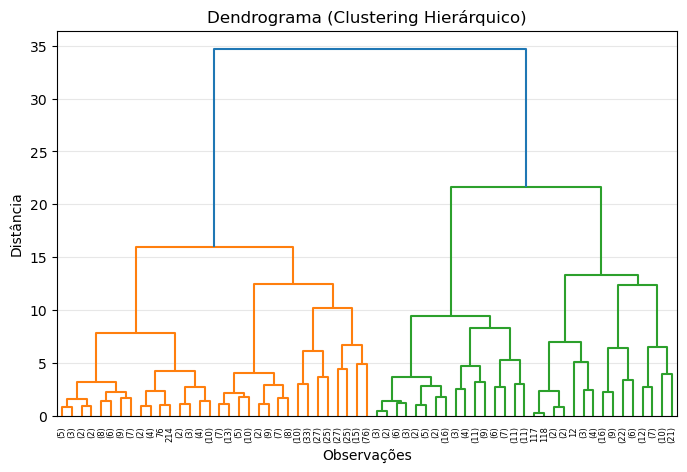

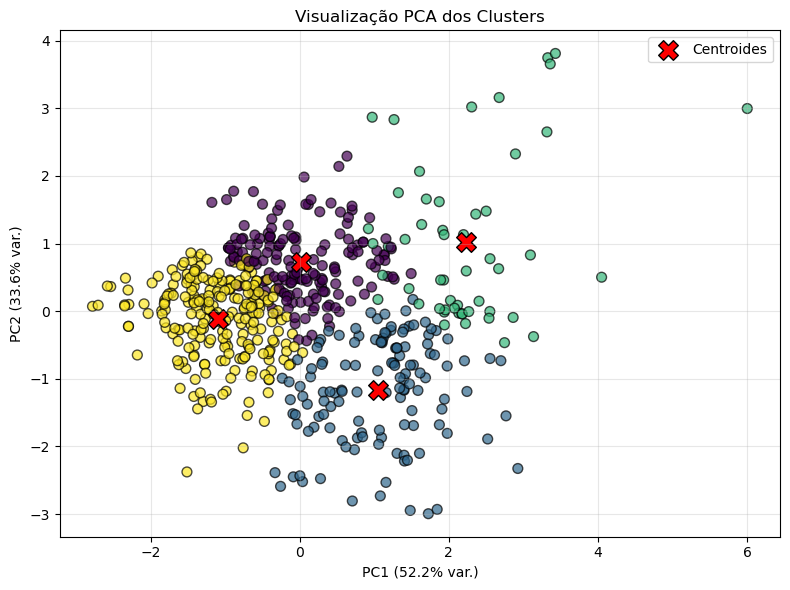

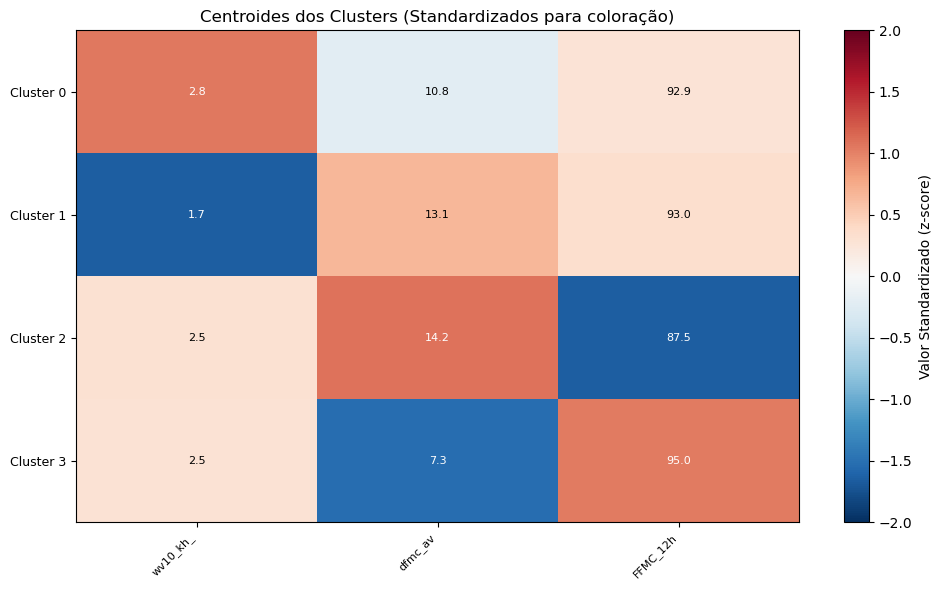


Resumo dos clusters:

Cluster 0: 169 observações (28.8%)
  Erro médio: 159.4% | Viés médio: +108.2%

Cluster 1: 130 observações (22.2%)
  Erro médio: 123.5% | Viés médio: +54.3%

Cluster 2: 53 observações (9.0%)
  Erro médio: 183.6% | Viés médio: +127.5%

Cluster 3: 234 observações (39.9%)
  Erro médio: 130.9% | Viés médio: +74.5%


In [170]:
# --- Parte 2: Aplicação de K-means e Plots detalhados ---
# Escolher número de clusters baseado na métrica desejada (ex: silhouette)
n_clusters = 4

print("="*80)
print(f"APLICANDO K-MEANS COM {n_clusters} CLUSTERS")
print("="*80)

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
cluster_labels = kmeans.fit_predict(X_scaled)
high_error_data['cluster'] = cluster_labels

# Distribuição dos clusters
print("\nDistribuição dos clusters:")
cluster_counts = high_error_data['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = count / len(high_error_data) * 100
    print(f"  Cluster {cluster_id}: {count} observações ({percentage:.1f}%)")

# --- Dendrograma ---
plt.figure(figsize=(8,5))
try:
    linked = linkage(X_scaled, method='ward')
    dendrogram(linked, truncate_mode='level', p=5)
    plt.title('Dendrograma (Clustering Hierárquico)')
    plt.xlabel('Observações')
    plt.ylabel('Distância')
    plt.grid(True, alpha=0.3, axis='y')
except:
    plt.text(0.5, 0.5, 'Não foi possível gerar dendrograma', ha='center', va='center')
plt.show()

# --- PCA para visualização dos clusters ---
plt.figure(figsize=(8,6))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_labels, cmap='viridis', s=50, alpha=0.7, edgecolors='black')
plt.scatter(pca.transform(kmeans.cluster_centers_)[:,0], pca.transform(kmeans.cluster_centers_)[:,1],
            c='red', s=200, marker='X', edgecolors='black', label='Centroides')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var.)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var.)')
plt.title('Visualização PCA dos Clusters')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- Heatmap dos centroides despadronizados com valores nas células ---
plt.figure(figsize=(10,6))

# Centroides despadronizados
centroids_original = scaler.inverse_transform(kmeans.cluster_centers_)

# Padronizar para cores (z-score por coluna)
centroids_std = (centroids_original - centroids_original.mean(axis=0)) / centroids_original.std(axis=0)

im = plt.imshow(centroids_std, cmap='RdBu_r', aspect='auto', vmin=-2, vmax=2)  # limitar para cores equilibradas
plt.xticks(range(len(cluster_vars)), [v[:8] for v in cluster_vars], rotation=45, ha='right', fontsize=8)
plt.yticks(range(n_clusters), [f'Cluster {i}' for i in range(n_clusters)], fontsize=9)
plt.title('Centroides dos Clusters (Standardizados para coloração)')

# Adicionar valores originais nas células
for i in range(n_clusters):
    for j in range(len(cluster_vars)):
        plt.text(j, i, f'{centroids_original[i,j]:.1f}', ha='center', va='center', 
                 color='white' if abs(centroids_std[i,j])>0.7 else 'black', fontsize=8)

plt.colorbar(im, label='Valor Standardizado (z-score)')
plt.tight_layout()
plt.show()


# --- Estatísticas por cluster ---
cluster_stats = {}
for cluster_id in range(n_clusters):
    cluster_data = high_error_data[high_error_data['cluster']==cluster_id]
    stats = {
        'n_obs': len(cluster_data),
        'perc_total': len(cluster_data)/len(high_error_data)*100
    }
    for var in cluster_vars:
        stats[f'{var}_mean'] = cluster_data[var].mean()
        stats[f'{var}_std'] = cluster_data[var].std()
        stats[f'{var}_median'] = cluster_data[var].median()
    stats['Error_p_ab_mean'] = cluster_data['Error_p_abs'].mean()
    stats['Error_p_ab_max'] = cluster_data['Error_p_abs'].max()
    stats['Err_pct_mean'] = cluster_data['Err_pct'].mean()
    cluster_stats[cluster_id] = stats

print("\nResumo dos clusters:")
for cluster_id, stats in cluster_stats.items():
    print(f"\nCluster {cluster_id}: {stats['n_obs']} observações ({stats['perc_total']:.1f}%)")
    print(f"  Erro médio: {stats['Error_p_ab_mean']:.1f}% | Viés médio: {stats['Err_pct_mean']:+.1f}%")
